In [1]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 10

import pandas as pd

color_map = {
    'cnt': 'm',
    'blu': 'b',
    'blv': 'c',
    'grn': 'g',
    'yel': 'y'
}

# periods = [('2024-07-11', '2024-07-18'),     # PERIODS FOR ALL TIME
#            ('2024-07-18', '2024-07-23'), 
#            ('2024-07-23', '2024-08-15'), 
#            ('2024-08-15', '2024-09-03'),
#            ('2024-09-03', '2024-09-10'), 
#            ]

periods = [('2024-07-11', '2024-07-17'),  # PERIODS FOR JUST CLOVER
           ('2024-07-18', '2024-07-24'), 
           ('2024-07-24', '2024-07-30')
           ]
periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in periods]

clover_start = pd.to_datetime('2024-07-11')
clover_end = pd.to_datetime('2024-07-30')

In [2]:
stim_ints = pd.read_csv('csvs/stimulus_intervals.csv', index_col=False)
stim_ints['interval'] = stim_ints['interval'].apply(lambda x: pd.Interval(pd.Timestamp(x.split(', ')[0].strip('[')), 
                                                            pd.Timestamp(x.split(', ')[1].strip(')')), 
                                                            closed='left'))

cam_ints = pd.read_csv('csvs/camera_intervals.csv', index_col=False)
cam_ints['interval'] = cam_ints['interval'].apply(lambda x: pd.Interval(pd.Timestamp(x.split(', ')[0].strip('[')), 
                                                            pd.Timestamp(x.split(', ')[1].strip(']')), 
                                                            closed='both'))

In [3]:
bombus_df = pd.read_csv('csvs/clean_dfs/bombus_df_manualedit.csv')
bombus_df['datetime'] = pd.to_datetime(bombus_df['datetime'])
bombus_df['color'] = None
for _, row in stim_ints.iterrows():
    mask = (bombus_df['pi'] == row['pi']) & (bombus_df['datetime'].between(row['interval'].left, row['interval'].right, inclusive='left'))
    bombus_df.loc[mask, 'color'] = row['color']
bombus_df = bombus_df.drop(columns=['filename', 'date', 'time_diff'])
bombus_df = bombus_df[['pi', 'datetime', 'color', 'species', 'sex']]

In [4]:
long_visits = pd.read_csv('stationary_bombus_filelist.txt', header=None, names=['filename'])
long_visits[['pi', 'datetime']] = long_visits['filename'].str.extract(r'^pi(\d+)_(\d{8}_\d{6})')
long_visits['pi'] = long_visits['pi'].astype(int)
long_visits = long_visits.drop(columns='filename')
long_visits['datetime'] = pd.to_datetime(long_visits['datetime'], format='%Y%m%d_%H%M%S')
long_visits = long_visits.sort_values(by=['pi', 'datetime'], ascending=[True, True]).reset_index(drop=True)

In [5]:
combined_df = pd.concat([bombus_df, long_visits], ignore_index=True)
combined_df = combined_df.sort_values(by=['pi', 'datetime'])
columns_to_fill = ['species', 'sex', 'color']
combined_df[columns_to_fill] = combined_df[columns_to_fill].ffill()
combined_df['time_diff'] = combined_df.groupby(['pi', 'color', 'species', 'sex'])['datetime'].diff()
combined_df['new_visit'] = (combined_df['time_diff'] > pd.Timedelta(seconds=4)) | (combined_df['time_diff'].isna())
combined_df['visit_id'] = combined_df.groupby(['species'])['new_visit'].cumsum()



In [6]:
visit_durations = (
    combined_df.groupby(['species', 'visit_id', 'pi', 'color'])['datetime']
    .agg(visit_start='min', visit_end='max')
    .reset_index())
visit_durations['duration'] = ((visit_durations['visit_end'] - visit_durations['visit_start']).dt.total_seconds())
visit_durations['pi_color'] = visit_durations['pi'].astype(str) + '_' + visit_durations['color']
visit_durations = visit_durations.sort_values(by='visit_start').reset_index(drop=True)
visit_durations = visit_durations.drop(index=[184, 187])

In [7]:
# MANUALLY ADD MULT VISITS

def add_rows(df, new_rows):
    new_df = pd.DataFrame(new_rows)
    new_df['visit_start'] = pd.to_datetime(new_df['visit_start'])
    new_df['visit_end'] = pd.to_datetime(new_df['visit_end'])
    new_df['duration'] = (new_df['visit_end'] - new_df['visit_start']).dt.total_seconds()
    for pi_color in new_df['pi_color'].unique():
        if pd.notna(pi_color):
            max_existing_id = df[df['pi_color'] == pi_color]['visit_id'].max()
            max_existing_id = max_existing_id if pd.notna(max_existing_id) else 0
            new_df.loc[new_df['pi_color'] == pi_color, 'visit_id'] = range(
                int(max_existing_id) + 1, int(max_existing_id) + 1 + len(new_df[new_df['pi_color'] == pi_color])
            )

    df = pd.concat([df, new_df], ignore_index=True)
    
    return df

new_rows = [
    {
        'species': 'vosnesenskii', 'pi': 9, 'color': 'grn',
        'visit_start': '2024-07-23 09:41:43', 'visit_end': '2024-07-23 10:02:38',
        'pi_color': '9_grn'
    },
    {
        'species': 'vosnesenskii', 'pi': 9, 'color': 'grn',
        'visit_start': '2024-07-23 10:02:19', 'visit_end': '2024-07-23 10:07:09',
        'pi_color': '9_grn'
    },
    {
        'species': 'vosnesenskii', 'pi': 9, 'color': 'grn',
        'visit_start': '2024-07-23 10:02:35', 'visit_end': '2024-07-23 10:05:19',
        'pi_color': '9_grn'
    }
]

visit_durations = add_rows(visit_durations, new_rows)

In [8]:
cumulative_visits = visit_durations.groupby(['pi_color', 'visit_start']).size().groupby(level=0).cumsum().reset_index(name='cumulative_count')
cumulative_color_visits = visit_durations.groupby(['color', 'visit_start']).size().groupby(level=0).cumsum().reset_index(name='cumulative_count')


visit_duration_distribution = visit_durations['duration']

# visit_durations.to_csv('csvs/bombus_visit_durations.csv', index=False)

### Calculate rate of bee capture in clover vs bare

In [9]:
# threshold = pd.to_datetime('2024-07-30')

# visit_durations_clover = visit_durations[visit_durations['visit_end'] <= threshold]
# visit_durations_bare = visit_durations[visit_durations['visit_end'] > threshold]

# cam_ints_clover = cam_ints[cam_ints['interval'].apply(lambda x: x.right <= threshold)]
# cam_ints_bare = cam_ints[cam_ints['interval'].apply(lambda x: x.left > threshold)]

# cam_ints_clover['duration_hours'] = cam_ints_clover['interval'].apply(lambda x: (x.right - x.left).total_seconds() / 3600)
# cam_ints_bare['duration_hours'] = cam_ints_bare['interval'].apply(lambda x: (x.right - x.left).total_seconds() / 3600)

# clover_visits = visit_durations_clover.groupby('pi').size().rename('visit_count')
# bare_visits = visit_durations_bare.groupby('pi').size().rename('visit_count')
# clover_runtime = cam_ints_clover.groupby('pi')['duration_hours'].sum().rename('total_runtime_hours')
# bare_runtime = cam_ints_bare.groupby('pi')['duration_hours'].sum().rename('total_runtime_hours')

# clover_summary = pd.concat([clover_visits, clover_runtime], axis=1)
# bare_summary = pd.concat([bare_visits, bare_runtime], axis=1)

# clover_summary['visits_per_hour'] = clover_summary['visit_count'] / clover_summary['total_runtime_hours']
# bare_summary['visits_per_hour'] = bare_summary['visit_count'] / bare_summary['total_runtime_hours']
# print()
# print('clover average visit per trap per hour:', clover_summary['visits_per_hour'].mean())
# print('bare average visit per trap per hour:', bare_summary['visits_per_hour'].mean())
# print()


In [28]:
threshold = pd.to_datetime('2024-07-30')

visit_durations_clover = visit_durations[visit_durations['visit_end'] < threshold]
visit_durations_bare = visit_durations[visit_durations['visit_end'] > threshold]

visit_counts_clover = len(visit_durations[visit_durations['visit_end'] <= threshold])
visit_counts_bare = len(visit_durations[visit_durations['visit_end'] > threshold])

cam_ints['duration'] = cam_ints['interval'].apply(lambda x: x.right - x.left)
before_or_on = cam_ints[cam_ints['interval'].apply(lambda x: x.right <= threshold)]
after = cam_ints[cam_ints['interval'].apply(lambda x: x.left > threshold)]
total_before_or_on = before_or_on['duration'].sum()
total_after = after['duration'].sum()

print("Total duration of intervals ending on or before 2024-07-30 (seconds):", total_before_or_on.total_seconds())
print("Total duration of intervals starting after 2024-07-30 (seconds):", total_after.total_seconds())
print()
print('visit counts clover:', visit_counts_clover)
print('visit counts bare:', visit_counts_bare)
print()
print(f'clover avg visits per trap per day: {(visit_counts_clover/(total_before_or_on.total_seconds()/3600/24))/10}')
print(f'bare avg visits per trap per day: {(visit_counts_bare/(total_after.total_seconds()/3600/24))/10}')

Total duration of intervals ending on or before 2024-07-30 (seconds): 6970149.0
Total duration of intervals starting after 2024-07-30 (seconds): 13302447.0

visit counts clover: 279
visit counts bare: 16

clover avg visits per trap per day: 0.3458405265081134
bare avg visits per trap per day: 0.010392072977249974


In [11]:
visit_durations_clover.to_csv('csvs/visit_durations_clover.csv', index=False)

### Subsample early 1hz Pis (how does phase of subsampling affect visit counts):


In [12]:
onehz_camtimes_pi3 = pd.read_csv('csvs/onehz_visits_pi3.csv', index_col=0, parse_dates=['datetime'])
onehz_camtimes_pi10 = pd.read_csv('csvs/onehz_visits_pi10.csv', index_col=0, parse_dates=['datetime'])

pi3_subsampled_p0 = onehz_camtimes_pi3.iloc[::2]
pi3_subsampled_p1 = onehz_camtimes_pi3.iloc[1::2]
pi10_subsampled_p0 = onehz_camtimes_pi10.iloc[::2]
pi10_subsampled_p1 = onehz_camtimes_pi10.iloc[1::2]

onehz_visits_pi3 = combined_df[(combined_df['pi'] == 3) & (combined_df['datetime'] < '2024-07-17')]
onehz_visits_pi10 = combined_df[(combined_df['pi'] == 10) & (combined_df['datetime'] < '2024-07-17')]
shortvisits_pi3 = onehz_visits_pi3[onehz_visits_pi3['visit_id'] != 46]

In [13]:
print(f'pi3 phase 0 = {len(pi3_subsampled_p0[pi3_subsampled_p0['datetime'].isin(shortvisits_pi3['datetime'])])}')
print(f'pi3 phase 1 = {len(pi3_subsampled_p1[pi3_subsampled_p1['datetime'].isin(shortvisits_pi3['datetime'])])}\n')

print(f'pi10 phase 0 = {len(pi10_subsampled_p0[pi10_subsampled_p0['datetime'].isin(onehz_visits_pi10['datetime'])])}')
print(f'pi10 phase 1 = {len(pi10_subsampled_p1[pi10_subsampled_p1['datetime'].isin(onehz_visits_pi10['datetime'])])}')

pi3 phase 0 = 2
pi3 phase 1 = 2

pi10 phase 0 = 4
pi10 phase 1 = 3


In [14]:
visit_durations['duration_adj'] = visit_durations['duration'] + 1
color_visit_durations = visit_durations.groupby('color')['duration_adj'].sum().astype(int)
color_total_counts = visit_durations.groupby('color')['pi'].count()
color_visit_durations / color_total_counts

color
blu     2.025641
blv     1.100000
cnt    22.117021
grn    79.867647
yel    58.470588
dtype: float64

### Distribution of dwell time
- VERIFY visit duration metric

yel: 1.0, 58.470588235294116
blu: 1.0, 2.0256410256410255
blv: 1.0, 1.1
grn: 1.0, 79.86764705882354
cnt: 1.0, 22.117021276595743


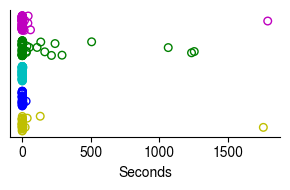

In [15]:
import numpy as np

new_order = ['yel', 'blu', 'blv','grn', 'cnt']

name_map = {
    'cnt': 'Contrast + UV',
    'blu': 'Blue',
    'blv': 'Blue + UV',
    'grn': 'Green',
    'yel': 'Yellow'
}

fig, ax = plt.subplots(figsize=(3, 2))

for i, color in enumerate(new_order):
    group = visit_durations[visit_durations['color'] == color]
    y = i + np.random.uniform(-0.3, 0.3, size=len(group))
    ax.scatter(group['duration_adj'], y, edgecolor=color_map[color], facecolor='none', label=color, s=30, linewidths=1, alpha=1)
    median = group['duration_adj'].median()
    avg = group['duration_adj'].mean()
    print(f'{color}: {median}, {avg}')

ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('Seconds')
plt.tight_layout()
# plt.savefig('figs/visit_duration_scatter.png', format='png', dpi=300)


yel: median=1.00, mean=6.91, n=33
blu: median=1.00, mean=1.32, n=38
blv: median=1.00, mean=1.02, n=59
grn: median=1.00, mean=28.82, n=65
cnt: median=1.00, mean=3.09, n=93


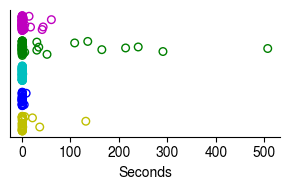

In [16]:
fig, ax = plt.subplots(figsize=(3, 2))

for i, color in enumerate(new_order):
    group = visit_durations[visit_durations['color'] == color]
    
    # 99% confidence interval bounds
    mean = group['duration_adj'].mean()
    std = group['duration_adj'].std()
    z = 2.576  # 99% CI z-score
    lower = mean - z * std
    upper = mean + z * std
    
    # Filter based on 99% CI
    filtered = group[(group['duration_adj'] >= lower) & (group['duration_adj'] <= upper)]

    # Jitter y-values
    y = i + np.random.uniform(-0.3, 0.3, size=len(filtered))

    ax.scatter(
        filtered['duration_adj'], y,
        edgecolor=color_map[color], facecolor='none',
        label=color, s=30, linewidths=1, alpha=1
    )

    # Print stats
    median = filtered['duration_adj'].median()
    avg = filtered['duration_adj'].mean()
    print(f'{color}: median={median:.2f}, mean={avg:.2f}, n={len(filtered)}')

ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('Seconds')
plt.tight_layout()

### Calculate visits per 10k photos each day

In [17]:
cumulative_color_visits['date'] = cumulative_color_visits['visit_start'].dt.date
cumulative_color_visits = cumulative_color_visits.groupby(['color','date']).size().reset_index(name='visit_count')

In [18]:
cumulative_color_visits

,color,date,visit_count
0,blu,2024-07-11,1
1,blu,2024-07-12,1
2,blu,2024-07-13,3
3,blu,2024-07-14,4
4,blu,2024-07-15,2
...,...,...,...
86,yel,2024-07-27,2
87,yel,2024-07-28,1
88,yel,2024-07-29,1
89,yel,2024-08-01,1


In [19]:
date_photo_counts = pd.read_csv('csvs/date_color_counts.csv', index_col=False)
date_photo_counts['date'] = pd.to_datetime(date_photo_counts['date']).dt.date
date_photo_counts['count_per_10k'] = date_photo_counts['count']/10000
date_photo_counts

,color,date,count,count_per_10k
0,blu,2024-07-11,18400,1.8400
1,blu,2024-07-12,18400,1.8400
2,blu,2024-07-13,26524,2.6524
3,blu,2024-07-14,53297,5.3297
4,blu,2024-07-15,35075,3.5075
...,...,...,...,...
269,yel,2024-08-29,47623,4.7623
270,yel,2024-08-30,42781,4.2781
271,yel,2024-09-03,33030,3.3030
272,yel,2024-09-04,47499,4.7499


### NUMBER OF IMAGES TAKEN FOR EACH COLOR

In [32]:
clover_date_photo_counts = date_photo_counts[date_photo_counts['date'] < pd.to_datetime('2024-07-30').date()]
clover_date_photo_counts.groupby('color')['count'].sum()

color
blu    1061467
blv    1090255
cnt    1157578
grn    1185447
yel    1212146
Name: count, dtype: int64

In [ ]:
merge_photos_visits = pd.merge(date_photo_counts, cumulative_color_visits, on=['color', 'date'], how='inner')
merge_photos_visits['visits_per_10k'] = merge_photos_visits['visit_count']/merge_photos_visits['count_per_10k']
# merge_photos_visits['cumulative_visits'] = merge_photos_visits.groupby('color')['visits_per_10k'].cumsum()
merge_photos_visits
merge_photos_visits_filtered = merge_photos_visits[merge_photos_visits['date'] <= merge_photos_visits['date'].min() + pd.Timedelta(days=18)]
merge_photos_visits_filtered['date'] = pd.to_datetime(merge_photos_visits_filtered['date'])
merge_photos_visits_filtered['day'] = (merge_photos_visits_filtered['date'] - merge_photos_visits_filtered['date'].min()).dt.days +1
merge_photos_visits_filtered['cumulative_visits'] = merge_photos_visits_filtered.groupby('color')['visits_per_10k'].cumsum()
merge_photos_visits_filtered

/tmp/ipykernel_475738/2716110542.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_photos_visits_filtered['date'] = pd.to_datetime(merge_photos_visits_filtered['date'])
/tmp/ipykernel_475738/2716110542.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_photos_visits_filtered['day'] = (merge_photos_visits_filtered['date'] - merge_photos_visits_filtered['date'].min()).dt.days +1
/tmp/ipykernel_475738/2716110542.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,color,date,count,count_per_k,visit_count,visits_per_10k,day,cumulative_visits
0,blu,2024-07-11,18400,1.8400,1,0.543478,1,0.543478
1,blu,2024-07-12,18400,1.8400,1,0.543478,2,1.086957
2,blu,2024-07-13,26524,2.6524,3,1.131051,3,2.218008
3,blu,2024-07-14,53297,5.3297,4,0.750511,4,2.968519
4,blu,2024-07-15,35075,3.5075,2,0.570207,5,3.538726
...,...,...,...,...,...,...,...,...
84,yel,2024-07-24,92785,9.2785,1,0.107776,14,6.258333
85,yel,2024-07-25,92735,9.2735,1,0.107834,15,6.366167
86,yel,2024-07-27,92584,9.2584,2,0.216020,17,6.582187
87,yel,2024-07-28,92810,9.2810,1,0.107747,18,6.689934


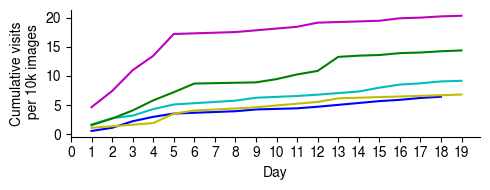

In [ ]:
plt.figure(figsize=(5, 2))

for color, group in merge_photos_visits_filtered.groupby('color'):
    plt.plot(group['day'], group['cumulative_visits'],
             label=color, color=color_map.get(color))

plt.xlabel('Day')
plt.ylabel('Cumulative visits\n per 10k images')
plt.yticks([0, 5, 10, 15, 20])
plt.xticks(range(0,20))

plt.tight_layout()
plt.savefig('figs/cumulative_visits_per_10k.svg', format='svg')

In [ ]:
merge_photos_visits_filtered

,color,date,count,count_per_k,visit_count,visits_per_10k,day,cumulative_visits
0,blu,2024-07-11,18400,1.8400,1,0.543478,1,0.543478
1,blu,2024-07-12,18400,1.8400,1,0.543478,2,1.086957
2,blu,2024-07-13,26524,2.6524,3,1.131051,3,2.218008
3,blu,2024-07-14,53297,5.3297,4,0.750511,4,2.968519
4,blu,2024-07-15,35075,3.5075,2,0.570207,5,3.538726
...,...,...,...,...,...,...,...,...
84,yel,2024-07-24,92785,9.2785,1,0.107776,14,6.258333
85,yel,2024-07-25,92735,9.2735,1,0.107834,15,6.366167
86,yel,2024-07-27,92584,9.2584,2,0.216020,17,6.582187
87,yel,2024-07-28,92810,9.2810,1,0.107747,18,6.689934


In [ ]:
# FINAL CUMULATIVE COUNTS PER 10K IMAGES

merge_photos_visits_filtered.groupby('color')['visits_per_10k'].sum().reset_index()

,color,visits_per_10k
0,blu,6.433264
1,blv,9.169406
2,cnt,20.355519
3,grn,14.390712
4,yel,6.811046


In [ ]:
from scipy.stats import linregress
from datetime import datetime 

start_date = pd.to_datetime("2024-07-11")
end_date = pd.to_datetime("2024-07-15")
subset = merge_photos_visits_filtered[
    (merge_photos_visits_filtered['date'] >= start_date) &
    (merge_photos_visits_filtered['date'] <= end_date)
]
daily_cum = subset.groupby(['color', 'date'])['cumulative_visits'].sum().reset_index()


rates = []
for color in daily_cum['color'].unique():
    color_df = daily_cum[daily_cum['color'] == color].sort_values('date')
    x = color_df['date'].map(datetime.toordinal)
    y = color_df['cumulative_visits']
    
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    rates.append({
        'color': color,
        'cumulative_rate_per_day': slope,
        'r_squared': r_value**2,
        'p_value': p_value
    })

cumulative_rates_df = pd.DataFrame(rates).sort_values(by='cumulative_rate_per_day', ascending=False)

cumulative_rates_df

,color,cumulative_rate_per_day,r_squared,p_value
2,cnt,3.122220,0.996449,0.000090
3,grn,1.444011,0.995119,0.000145
1,blv,0.848234,0.987807,0.000573
0,blu,0.787206,0.986296,0.000684
4,yel,0.541693,0.799698,0.040616


### Alt approaches to visualizing cumulative counts

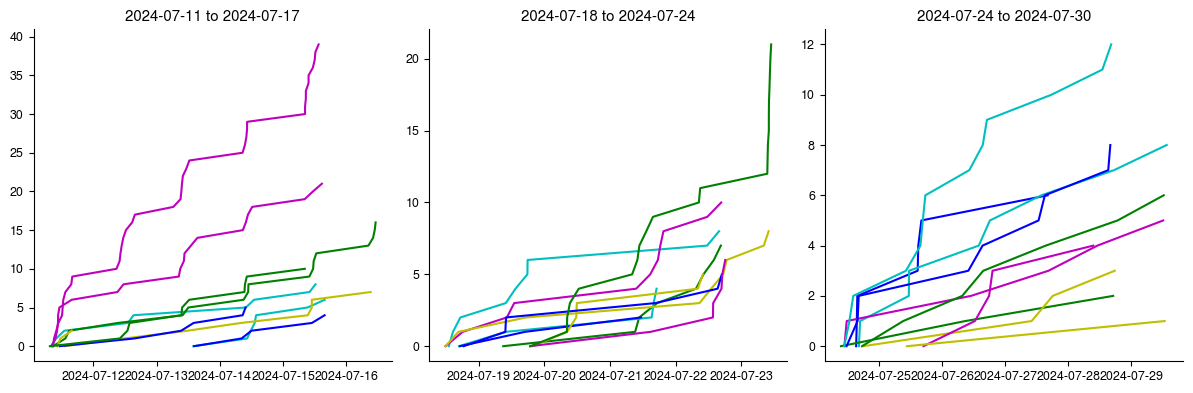

In [ ]:
# CUMULATIVE COUNTS BY TRAP, THREE PERIODS, RESET TO ZERO EACH PERIOD

fig, axes = plt.subplots(1, len(periods), figsize=(4 * len(periods), 4))

for i, (start, end) in enumerate(periods):
    period_subset = cumulative_visits[
        (cumulative_visits['visit_start'] >= start) & (cumulative_visits['visit_start'] <= end)
    ].copy()
    
    period_subset['adjusted_cumulative_count'] = (
        period_subset.groupby('pi_color')['cumulative_count']
        .transform(lambda x: x - x.min())
    )

    ax = axes[i] if len(periods) > 1 else axes 
    for key, group in period_subset.groupby('pi_color'):
        color_key = key.split('_')[-1]
        line_color = color_map.get(color_key, 'k')
        ax.plot(group['visit_start'], group['adjusted_cumulative_count'], label=key, color=line_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f'{start.date()} to {end.date()}')

plt.tight_layout()

In [ ]:
treatment_times = pd.read_csv('csvs/treatment_times_fixed.csv', index_col=False)
treatment_times['datetime'] = pd.to_datetime(treatment_times['datetime'], format= "%Y-%m-%d %H:%M:%S")
treatment_times['date'] = pd.to_datetime(treatment_times['date'], format= "%Y-%m-%d")

In [ ]:
treatment_times['pi_color'] = treatment_times['pi'].astype(str) + '_' + treatment_times['color']
treatment_times = treatment_times.sort_values('datetime')

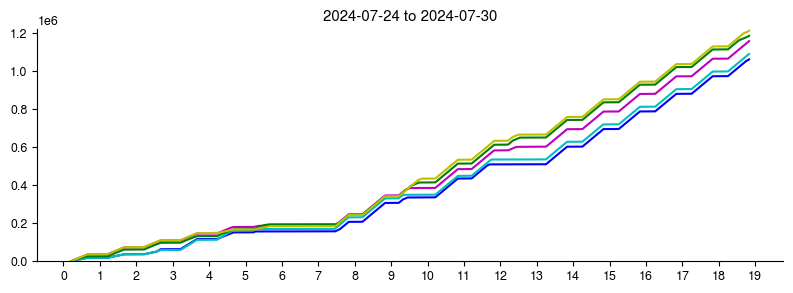

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))

period_subset = treatment_times[
    (treatment_times['datetime'] >= clover_start) & (treatment_times['datetime'] <= clover_end)
].copy()


image_counts = (
period_subset.groupby(['color', 'datetime'])
.size()
.groupby(level=0)
.cumsum()
.reset_index(name='cumulative_count')   
)

# image_counts['adjusted_cumulative_count'] = (
# image_counts.groupby('color')['cumulative_count']
# .transform(lambda x: x - x.min())
# )

for key, group in image_counts.groupby('color'):
    color_key = key.split('_')[-1]
    pi_key = key.split('_')[0]
    line_color = color_map.get(color_key, 'k')
    ax.plot(group['datetime'], group['cumulative_count'], label=key, color=line_color)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(f'{start.date()} to {end.date()}')
ax.set_xticks(pd.date_range(start=clover_start, end=clover_end, freq='D'))
ax.set_xticklabels([(tick - clover_start).days for tick in pd.date_range(start=clover_start, end=clover_end, freq='D')])
ax.set_ylim(0, 1220000)
plt.tight_layout()

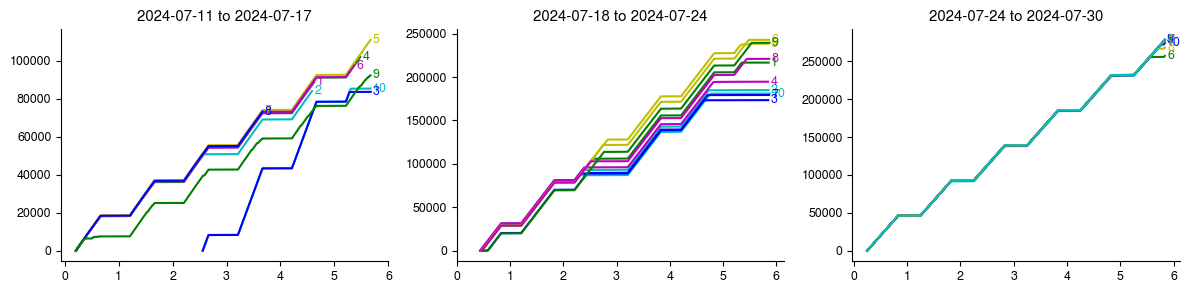

In [ ]:
color_map = {
    'cnt': 'm',
    'blu': 'b',
    'blv': 'c',
    'grn': 'g',
    'yel': 'y'
}

fig, axes = plt.subplots(1, len(periods), figsize=(4 * len(periods), 3))

for i, (start, end) in enumerate(periods):
    period_subset = treatment_times[
        (treatment_times['datetime'] >= start) & (treatment_times['datetime'] <= end)
    ].copy()


    image_counts = (
    period_subset.groupby(['pi_color', 'datetime'])
    .size()
    .groupby(level=0)
    .cumsum()
    .reset_index(name='cumulative_count')   
    )

    image_counts['adjusted_cumulative_count'] = (
    image_counts.groupby('pi_color')['cumulative_count']
    .transform(lambda x: x - x.min())
    )

    ax = axes[i]
    for key, group in image_counts.groupby('pi_color'):
        color_key = key.split('_')[-1]
        pi_key = key.split('_')[0]
        line_color = color_map.get(color_key, 'k')
        ax.plot(group['datetime'], group['adjusted_cumulative_count'], label=key, color=line_color)
        ax.text(
            group['datetime'].iloc[-1]+ pd.Timedelta(seconds=3600),
            group['adjusted_cumulative_count'].iloc[-1]+0.7,
            f'{pi_key}',
            color=line_color,
            fontsize=9,
            verticalalignment='center'
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f'{start.date()} to {end.date()}')
    ax.set_xticks(pd.date_range(start=start, end=end, freq='D'))
    ax.set_xticklabels([(tick - start).days for tick in pd.date_range(start=start, end=end, freq='D')])


plt.tight_layout()

<>:24: SyntaxWarning: invalid escape sequence '\i'
<>:24: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_4179113/4121611675.py:24: SyntaxWarning: invalid escape sequence '\i'
  ax.set_ylabel('$\it{Bombus}$ visits')


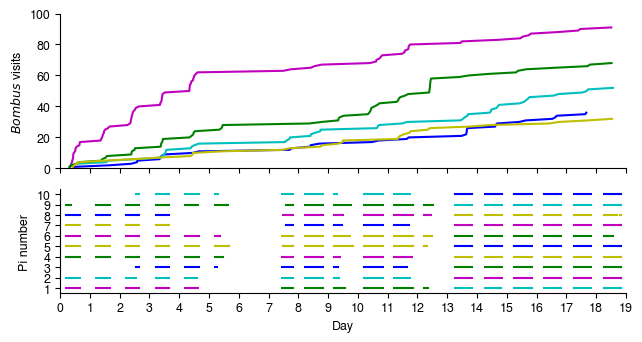

In [ ]:
# CUMULATIVE COUNTS BY COLOR, ALL PERIODS

fig, axes = plt.subplots(2, 1, figsize=(6.5, 3.5), gridspec_kw={'height_ratios': [3, 2]}, sharex=True)

period_subset_visits = cumulative_color_visits[
    (cumulative_color_visits['visit_start'] >= clover_start) & (cumulative_color_visits['visit_start'] <= clover_end)
].copy()

period_subset_visits['visit_start_days'] = (period_subset_visits['visit_start'] - clover_start).dt.total_seconds() / (24 * 3600)
    
ax = axes[0]

for key, group in period_subset_visits.groupby('color'):
    color_key = key
    line_color = color_map.get(color_key, 'k')
    ax.plot(group['visit_start_days'], group['cumulative_count'], label=key, color=line_color)

# ax.set_title(f'{clover_start.date()} to {clover_end.date()}')
ax.set_xticks(range(20))
ax.set_xticklabels([])
ax.set_xlim(0, 19)
ax.set_ylim(0, 100)

ax.set_ylabel('$\it{Bombus}$ visits')

ax = axes[1]

period_subset = cam_ints[
    cam_ints['interval'].apply(lambda x: clover_start <= x.left and x.right <= clover_end)
]

for _, row in period_subset.iterrows():
    ax.plot([(row['interval'].left - clover_start).total_seconds() / (24 * 3600), 
             (row['interval'].right - clover_start).total_seconds() / (24 * 3600)], 
            [row['pi'], row['pi']], color=color_map[row['color']])


# ax.set_xticks(range(7))
ax.set_xticklabels(range(20))
ax.set_yticks(combined_df['pi'].unique())
ax.set_yticklabels(combined_df['pi'].unique())
ax.set_xlabel('Day')

ax.set_ylabel('Pi number')

plt.tight_layout()
# plt.savefig('figs/visits_intervals.png', format='png', dpi=300 )

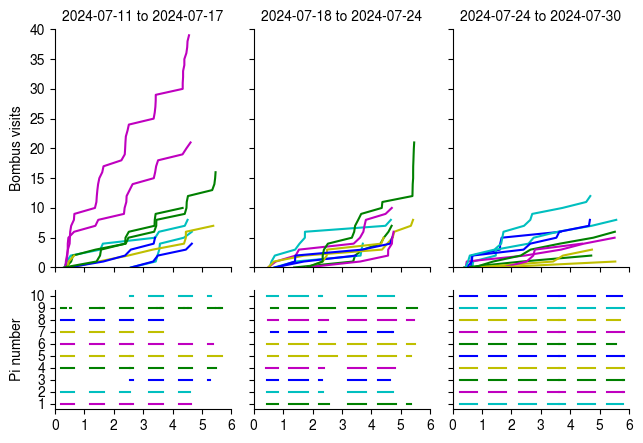

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(6.5, 4.5), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

num_periods = len(periods)

for idx, (start, end) in enumerate(periods):
    ax = axes[0, idx]

    period_subset_visits = cumulative_visits[
        (cumulative_visits['visit_start'] >= start) & (cumulative_visits['visit_start'] <= end)
    ].copy()

    period_subset_visits['visit_start_days'] = (period_subset_visits['visit_start'] - start).dt.total_seconds() / (24 * 3600)

    period_subset_visits['adjusted_cumulative_count'] = (
        period_subset_visits.groupby('pi_color')['cumulative_count']
        .transform(lambda x: x - x.min())
    )

    for key, group in period_subset_visits.groupby('pi_color'):
        color_key = key.split('_')[-1]
        pi_key = key.split('_')[0]
        line_color = color_map.get(color_key, 'k')
        
        ax.plot(group['visit_start_days'], group['adjusted_cumulative_count'], label=key, color=line_color)
        
        # ax.text(
        #     group['visit_start_days'].iloc[-1] + 0.1,  
        #     group['adjusted_cumulative_count'].iloc[-1] + 0.5,
        #     f'{pi_key}',
        #     color=line_color,
        #     fontsize=9,
        #     verticalalignment='center'
        # )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f'{start.date()} to {end.date()}', fontsize=10)
    ax.set_xticks(range(7))
    ax.set_xticklabels([])
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 40)
    ax.set_yticks(range(0,45,5))
    ax.set_yticklabels(range(0,45,5), fontsize=10)
    
    if idx == 0:
        ax.set_ylabel('Bombus visits', fontsize=10)
    if idx != 0:
        ax.set_yticklabels([])

for idx, (start, end) in enumerate(periods):
    ax = axes[1, idx]

    period_subset = cam_ints[
        cam_ints['interval'].apply(lambda x: start <= x.left and x.right <= end)
    ]

    for _, row in period_subset.iterrows():
        ax.plot([(row['interval'].left - start).total_seconds() / (24 * 3600), 
                 (row['interval'].right - start).total_seconds() / (24 * 3600)], 
                [row['pi'], row['pi']], color=color_map[row['color']])

    ax.set_xticks(range(7))
    ax.set_xticklabels(range(7), fontsize=10)
    ax.set_yticks(combined_df['pi'].unique())
    ax.set_yticklabels(combined_df['pi'].unique(), fontsize=10)
    if idx != 0:
        ax.set_yticklabels([])
    ax.set_xlim(0, 6)
    
    if idx == 0:
        ax.set_ylabel('Pi number', fontsize=10)

plt.tight_layout()
# plt.show()

# plt.savefig('figs/cumulative_bombus_linear_pitimes.png', format='png', dpi=300)